<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Part 1: Data Scraping / Cleaning / EDA

### Problem Statement

As a data scientist at HBO, I wish to collect information from 2 subreddits on Reddit containing posts from our biggest competitor, Netflix, as a comparison. By using NLP to train a classifier, the use cases for this info may be used for the following:

- Identify popular shows and genres
    + identify which aspects of the show resonate most strongly with fans by analysing language used in posts/comments
- Sentiment analysis
    + identify potential areas of improvement in shows with negative sentiment
    + assess the appeal of shows to a specific demographic, impact decision-making around content development
    + monitor brand reputation
- Optimise marketing messages and ad campaigns
    + identify key messages that resonate with target audience
    + identify potential areas for product differentiation
- Track competitor performance
    + insights into strengths and weaknesses of competitor
- Detect emerging trends
    + capitalise on any surge in posts relating to a genre/theme by developing new shows/ promote existing shows
- Identify content gaps
    + any gaps driving audiences to other competitors?
---

### Methodology
1. Data Scraping
2. Data Cleaning
3. EDA
4. Modeling
5. Evaluation of models

In [253]:
# Importing Libraries

from time import sleep
import numpy as np
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

### Data Scraping

We will be scraping the following subreddits:
- [HBO](https://www.reddit.com/r/hbo/)
- [Netflix](https://www.reddit.com/r/netflix/)

Using [Pushshift](https://github.com/pushshift/api), there are two main endpoints used to search all publicly available comments and submissions on Reddit:

- /reddit/search/comment
- /reddit/search/submission


For this project, I have decided to focus on Submissions as I want to identify in which subreddit a particular submission would fall.

url = 'https://api.pushshift.io/reddit/search/submission'

In [254]:
subreddits = ['hbo', 'netflix']

In [255]:
def subreddit_pull(url = 'https://api.pushshift.io/reddit/search/submission/',
                   subs = ['hbo', 'netflix'],
                   size = 1000):

    hbo_df = pd.DataFrame()
    netflix_df = pd.DataFrame()

    for sub in subs:
        params = {'subreddit': sub, 'size': size}
        if sub == 'hbo':
            df = hbo_df
        elif sub == 'netflix':
            df = netflix_df

        while len(df) < 1000 or len(df[df['selftext'].notnull()]) < 1000:
            try:
                res = requests.get(url, params)
                res.raise_for_status()
                data = res.json()
                posts = data['data']
                if not posts:
                    break
                if 'is_robot_indexable' in posts[0]:
                    df_sub = pd.DataFrame(posts)[['subreddit', 'title', 'selftext']]
                else:
                    df_sub = pd.DataFrame(posts)[['subreddit', 'title', 'selftext']]
                    
                # Filter posts with combined title and selftext length > 30
                df_sub = df_sub[df_sub.apply(lambda x: len(str(x['title']) + str(x['selftext'])) > 30, axis=1)]
                
                df = pd.concat([df, df_sub])
                params['before'] = posts[-1]['created_utc']
                print(f"For subreddit {sub}, {len(posts)} completed")
                sleep(1)
            except requests.exceptions.HTTPError as e:
                print(f"Error: {e}")
                sleep(1)

        if sub == 'hbo':
            hbo_df = df.iloc[:1000]
            hbo_df.to_csv('../data/hbo_submissions.csv', header=True, index=False)
        elif sub == 'netflix':
            netflix_df = df.iloc[:1000]
            netflix_df.to_csv('../data/netflix_submissions.csv', header=True, index=False)

    return hbo_df, netflix_df

In [256]:
hbo, netflix = subreddit_pull(url='https://api.pushshift.io/reddit/search/submission/',
                        subs=['hbo', 'netflix'],
                        size=1000)

For subreddit hbo, 1000 completed
For subreddit hbo, 997 completed
For subreddit netflix, 1000 completed
For subreddit netflix, 999 completed


In [257]:
print(hbo.shape)
print(netflix.shape)

(1000, 3)
(1000, 3)


In [258]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [259]:
hbo.head()

,subreddit,title,selftext
0,hbo,Ok favorite all time HBO Series and favorite c...,
1,hbo,[OC] HBO Series Season Premiere v. Finale (Cha...,
2,hbo,"anyone know the release date for ""White house ...","Can't seem to find it online, it just says mar..."
3,hbo,Who is your all time favorite character from a...,
4,hbo,My top 10 HBO series,1. The Wire\n2. Chernobyl \n3. The Sopranos\n4...


In [260]:
netflix.head()

,subreddit,title,selftext
0,netflix,Characters from Stranger Things generated by AI,
1,netflix,What’s your favorite movie or tv show to watch...,
2,netflix,Anyone watched Netflix’s In the Name of God: A...,
3,netflix,Im sorry but can someone explain this poster f...,
4,netflix,How do you share your Netflix account?,[removed]


### Data Cleaning

#### Removing '[removed]' and '[deleted]' values

As there are a large number of '[removed]' and '[deleted]' values in our data due to content moderation, we will omit these in our analysis.

In [261]:
# Replace '[removed]' with empty strings
hbo['selftext'] = hbo['selftext'].replace('[removed]', '')
netflix['selftext'] = netflix['selftext'].replace('[removed]', '')

In [262]:
# Replace '[deleted]' with empty strings
hbo['selftext'] = hbo['selftext'].replace('[deleted]', '')
netflix['selftext'] = netflix['selftext'].replace('[deleted]', '')

#### Combining 'title' and 'selftext' columns

In [263]:
hbo['combined'] = hbo['title'] + ' ' + hbo['selftext']
netflix['combined'] = netflix['title'] + ' ' + netflix['selftext']

In [264]:
netflix.combined.head()

0     Characters from Stranger Things generated by AI 
1    What’s your favorite movie or tv show to watch...
2    Anyone watched Netflix’s In the Name of God: A...
3    Im sorry but can someone explain this poster f...
4              How do you share your Netflix account? 
Name: combined, dtype: object

#### Removing 'title' and 'selftext' columns

In [265]:
# Remove the 'title' and 'selftext' columns from both dataframes
hbo = hbo.drop(['title', 'selftext'], axis=1)
netflix = netflix.drop(['title', 'selftext'], axis=1)

#### Removing URLs

In [266]:
print(hbo['combined'].str.contains('http').sum())
print(netflix['combined'].str.contains('http').sum())

54
32


In [267]:
# Remove URLs containing 'http' in the 'combined' column for hbo
hbo['combined'] = hbo['combined'].apply(lambda x: re.sub(r'http\S+', '', x))

# Remove URLs containing 'http' in the 'combined' column for netflix
netflix['combined'] = netflix['combined'].apply(lambda x: re.sub(r'http\S+', '', x))

#### Removing HTML newlines

In [268]:
print(hbo['combined'].str.contains('\n').sum())
print(netflix['combined'].str.contains('\n').sum())

129
218


In [269]:
# Remove '\n' characters from the 'combined' column for hbo
hbo['combined'] = hbo['combined'].apply(lambda x: x.replace('\n', ' '))

# Remove '\n' characters from the 'combined' column for netflix
netflix['combined'] = netflix['combined'].apply(lambda x: x.replace('\n', ' '))

#### Removing digits

In [270]:
# Remove all digits using regex
hbo['combined'] = hbo['combined'].apply(lambda x: re.sub(r'\d', '', x))
netflix['combined'] = netflix['combined'].apply(lambda x: re.sub(r'\d', '', x))

#### Remove non-alphanumeric characters except hyphen

In [271]:
hbo['combined'] = hbo['combined'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s-]', '', x))
netflix['combined'] = netflix['combined'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s-]', '', x))

#### Remove extra whitespaces

In [272]:
hbo['combined'] = hbo['combined'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
netflix['combined'] = netflix['combined'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

#### Remove punctuation marks

In [273]:
hbo['combined'] = hbo['combined'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
netflix['combined'] = netflix['combined'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

#### Remove usernames and hashtags

In [274]:
hbo['combined'] = hbo['combined'].apply(lambda x: re.sub(r'@[^\s]+|#\w+', ' ', x))
netflix['combined'] = netflix['combined'].apply(lambda x: re.sub(r'@[^\s]+|#\w+', ' ', x))

#### Remove non-English text

In [275]:
hbo['combined'] = hbo['combined'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', ' ', x))
netflix['combined'] = netflix['combined'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', ' ', x))

#### Removing duplicates

As duplicate entries would skew the trends found in our data, we will drop any duplicate entries.

In [276]:
hbo.drop_duplicates(subset = ['combined'], inplace=True)
netflix.drop_duplicates(subset = ['combined'], inplace=True)

### Exploratory Data Analysis

#### Distribution of subreddit post lengths

In [277]:
# Compute the length of each post in the 'combined' column
hbo['post_length'] = hbo['combined'].apply(lambda x: len(str(x)))
netflix['post_length'] = netflix['combined'].apply(lambda x: len(str(x)))

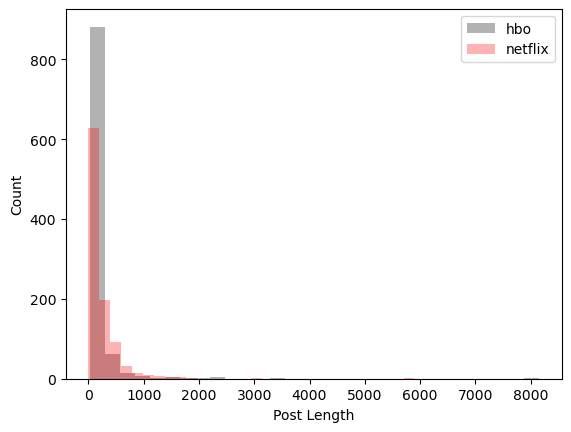

In [278]:
# Plot the distribution of post lengths for each subreddit using a histogram
fig, ax = plt.subplots()
ax.hist(hbo['post_length'], bins=30, alpha=0.3, color='black', label='hbo')
ax.hist(netflix['post_length'], bins=30, alpha=0.3, color='red', label='netflix')
ax.set_xlabel('Post Length')
ax.set_ylabel('Count')
ax.legend()
plt.show()

#### Remove unnecessary long posts

In [279]:
# Count the number of posts with a length greater than 2000 for each subreddit
hbo_count = hbo[hbo['post_length'] > 2000].shape[0]
netflix_count = netflix[netflix['post_length'] > 2000].shape[0]

# Print the results
print(f'Number of posts with a length greater than 2000 for hbo: {hbo_count}')
print(f'Number of posts with a length greater than 2000 for netflix: {netflix_count}')

Number of posts with a length greater than 2000 for hbo: 7
Number of posts with a length greater than 2000 for netflix: 2


As we can see that only a fraction of posts are greater than 2000 and given the propensity that this data will skew our model, we shall remove these posts from both subreddits.

In [280]:
# Remove posts with a length greater than 2000 for each subreddit
hbo = hbo[hbo['post_length'] <= 2000]
netflix = netflix[netflix['post_length'] <= 2000]

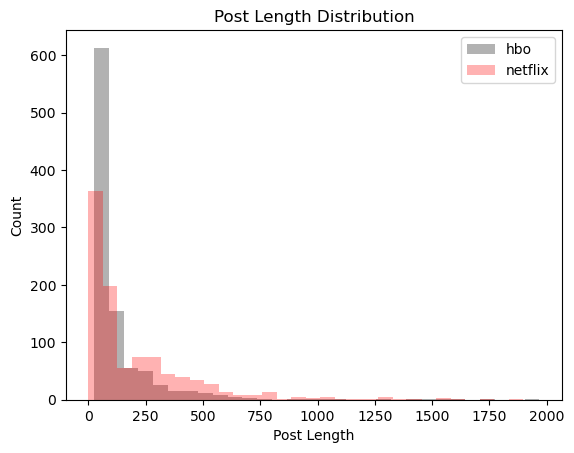

In [281]:
# Re-plot the distribution of post lengths for each subreddit using a histogram
fig, ax = plt.subplots()
ax.hist(hbo['post_length'], bins=30, alpha=0.3, color='black', label='hbo')
ax.hist(netflix['post_length'], bins=30, alpha=0.3, color='red', label='netflix')
ax.set_xlabel('Post Length')
ax.set_ylabel('Count')
ax.set_title('Post Length Distribution')
ax.legend()
plt.show()

#### Drop post_length < 20

It can be observed that r/Netflix generally has greater post lengths, even though both subreddits have similar medians. Since the shortest post lengths are only 1 or 2 words and may not be helpful in our classification, these will be dropped.

In [282]:
print(hbo[hbo['post_length'] < 20]['subreddit'].value_counts())
print(netflix[netflix['post_length'] < 20]['subreddit'].value_counts())

Series([], Name: subreddit, dtype: int64)
netflix    4
Name: subreddit, dtype: int64


In [283]:
hbo.drop(index=hbo[hbo['post_length'] < 20].index, inplace=True)
netflix.drop(index=netflix[netflix['post_length'] < 20].index, inplace=True)

#### Summary Statistics

In [284]:
print(round(hbo.post_length.describe(),1))
print()
print(round(netflix.post_length.describe(),1))

count     976.0
mean      137.5
std       203.4
min        24.0
25%        49.0
50%        69.0
75%       128.2
max      1968.0
Name: post_length, dtype: float64

count     981.0
mean      214.7
std       263.2
min        20.0
25%        50.0
50%        89.0
75%       294.0
max      1897.0
Name: post_length, dtype: float64


### Preprocessing

#### Tokenize text

By using a RegEx tokenizer, I will remove unnecessary characters (punctuation/symbols). Additionally, I will lowercase all strings.

In [285]:
print(hbo.combined.head())
print()
print(netflix.combined.head())

0    Ok favorite all time HBO Series and favorite c...
1    OC HBO Series Season Premiere v Finale Change ...
2    anyone know the release date for White house p...
3    Who is your all time favorite character from a...
4    My top HBO series The Wire Chernobyl The Sopra...
Name: combined, dtype: object

0      Characters from Stranger Things generated by AI
1    Whats your favorite movie or tv show to watch ...
2    Anyone watched Netflixs In the Name of God A H...
3    Im sorry but can someone explain this poster f...
4                How do you share your Netflix account
Name: combined, dtype: object


In [286]:
tokenizer = RegexpTokenizer(r'\w+')

In [287]:
# Tokenize 'combined' column in hbo
hbo_tokens = hbo['combined'].str.lower().apply(tokenizer.tokenize)

# Tokenize 'combined' column in netflix
netflix_tokens = netflix['combined'].str.lower().apply(tokenizer.tokenize)

In [288]:
print(hbo_tokens.head())
print()
print(netflix_tokens.head())

0    [ok, favorite, all, time, hbo, series, and, fa...
1    [oc, hbo, series, season, premiere, v, finale,...
2    [anyone, know, the, release, date, for, white,...
3    [who, is, your, all, time, favorite, character...
4    [my, top, hbo, series, the, wire, chernobyl, t...
Name: combined, dtype: object

0    [characters, from, stranger, things, generated...
1    [whats, your, favorite, movie, or, tv, show, t...
2    [anyone, watched, netflixs, in, the, name, of,...
3    [im, sorry, but, can, someone, explain, this, ...
4        [how, do, you, share, your, netflix, account]
Name: combined, dtype: object


#### Lemmatization

As the nature of my analysis requires a high level of accuracy and precision in text interpretation, I will lemmatize the subreddits instead of stemming them.

In [289]:
lemmatizer = WordNetLemmatizer()

# Lemmatize 'tokens' column in hbo except keyword 'us'
hbo['tokens_lem'] = hbo_tokens.apply(lambda x: [lemmatizer.lemmatize(token) if token != 'us' else 'us' for token in x])

# Lemmatize 'tokens' column in netflix
netflix['tokens_lem'] = netflix_tokens.apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

As tokens_lem is a list of words, I will transform it to be in string values.

In [290]:
# Convert tokens_lem to strings in hbo
hbo['tokens_lem'] = hbo['tokens_lem'].apply(lambda x: ' '.join(x))

# Convert tokens_lem to strings in netflix
netflix['tokens_lem'] = netflix['tokens_lem'].apply(lambda x: ' '.join(x))

#### Plot WordClouds to check for common words to add to Stopwords

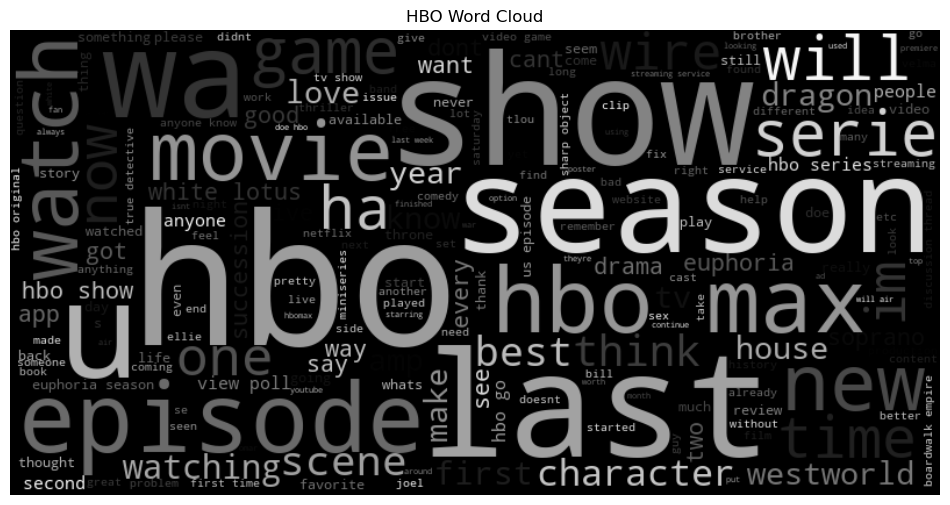

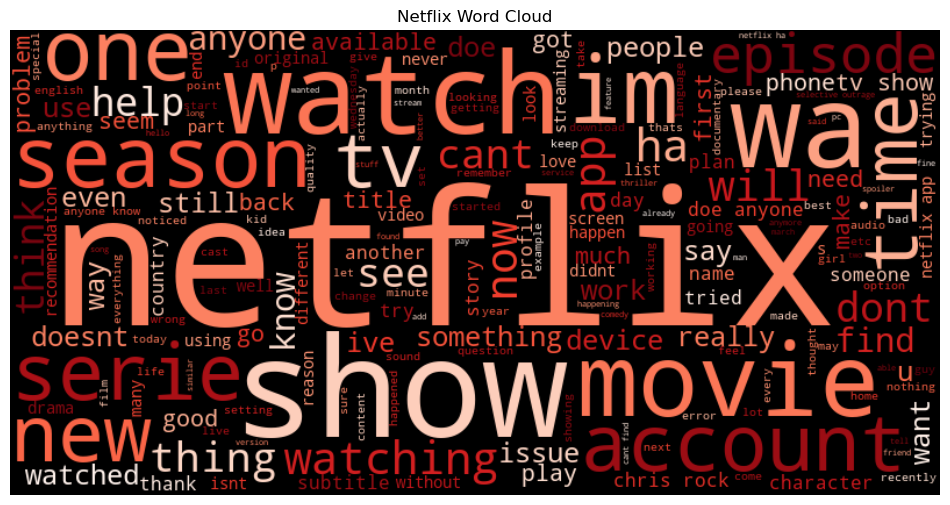

In [291]:
# Combine all text in the 'combined' column into a single string for each dataframe
hbo_text = ' '.join(hbo['tokens_lem'].tolist())
netflix_text = ' '.join(netflix['tokens_lem'].tolist())

# Generate a word cloud for HBO
hbo_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='gist_gray').generate(hbo_text)
plt.figure(figsize=(12, 8))
plt.imshow(hbo_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('HBO Word Cloud')
plt.show()

# Generate a word cloud for Netflix
netflix_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(netflix_text)
plt.figure(figsize=(12, 8))
plt.imshow(netflix_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Netflix Word Cloud')
plt.show()

#### Remove stopwords

In [292]:
# Define my custom stopwords using WordClouds above
my_stopwords = set(STOPWORDS)
my_stopwords.update(['will', 'something', 'seem', 'know', 'thing', 'give', 'dont', 've', 'even', 'make', 'will',
                'didnt', 'actually', 'using', 'let', 'new', 'view', 'poll', 'hi', 'hello', 'ampxb', 'shows', 'wont', 'gonna', 'going', 
                'try', 'tried', 'episode', 'want', 'think', 'doesnt', 'se', 'scene', 
                'watched', 'u', 'ive', 'im', 'p', 'help', 'got', 'anymore', 'watching', 'theyre', 'amp', 'said', 'like', 'just', 
                'does', 'much', 'anything', 'character', 'look', 'looking', 'probably', 'time', 'even', 'streaming', 'th', 'good', 
                'bad', 'play' 'really', 's', 'cant', 'say', 'thought', 'love', 'yet', 'stuff', 'watch', 'whats', 'use', 'currently', 
                'season', 'serie', 'series', 'show', 'youre', 'say', 'video', 'trying', 'movie', 'movies', 'episode', 'drama', 
                'tv', 'service', 'isnt', 'thats', 'hbo', 'hbos', 'netflix', 'netflixs'])

# Add my custom stopwords to the existing stopwords list
stopwords = set(CountVectorizer(stop_words='english').get_stop_words()).union(my_stopwords)
stopwords.remove('last')
stopwords.remove('us')

In [293]:
# Tokenize 'combined' column in hbo
hbo['tokens_lem'] = hbo_tokens.apply(lambda x: [lemmatizer.lemmatize(token) if token != 'us' else 'us' for token in x if token not in stopwords])

# Tokenize 'combined' column in netflix
netflix['tokens_lem'] = netflix_tokens.apply(lambda x: [lemmatizer.lemmatize(token) for token in x if token not in stopwords])

In [294]:
# Combine tokens into raw text strings in hbo
hbo['tokens_lem'] = hbo['tokens_lem'].apply(lambda x: ' '.join(x))

# Combine tokens into raw text strings in netflix
netflix['tokens_lem'] = netflix['tokens_lem'].apply(lambda x: ' '.join(x))

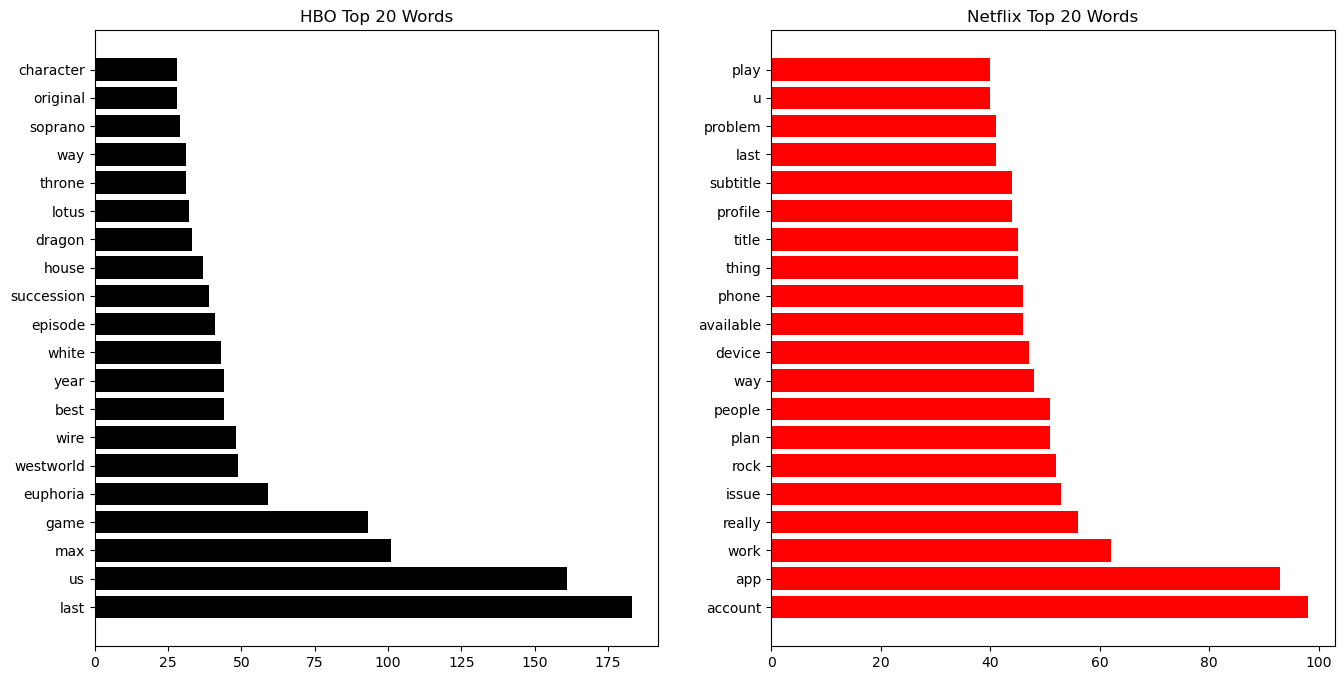

In [295]:
# tokenize the combined text data
hbo_words = " ".join(hbo['tokens_lem']).split()
netflix_words = " ".join(netflix['tokens_lem']).split()

# count the frequency of each word
hbo_word_counts = Counter(hbo_words)
netflix_word_counts = Counter(netflix_words)

# get the 20 most common words for each dataset
hbo_top_words = hbo_word_counts.most_common(20)
netflix_top_words = netflix_word_counts.most_common(20)

# plot bar chart for top 20 words in each dataset
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].barh([word[0] for word in hbo_top_words], [word[1] for word in hbo_top_words], color='black')
ax[0].set_title('HBO Top 20 Words')
ax[1].barh([word[0] for word in netflix_top_words], [word[1] for word in netflix_top_words], color='red')
ax[1].set_title('Netflix Top 20 Words')
plt.show()


#### Merging dataframes

In [296]:
hbo_netflix = pd.concat([hbo,netflix])

#### Converting HBO/Netflix into binary labels
+ 0 for HBO
+ 1 for Netflix

In [297]:
subreddit_binary = {'hbo': 0, 'netflix': 1}
hbo_netflix.replace({'subreddit': subreddit_binary}, inplace= True)

#### Save to CSV

In [298]:
hbo_netflix.to_csv('../data/hbo_netflix.csv')

### Vectorize text
+ Count Vectorizer
+ Count Vectorizer with n-grams
+ TF-IDF Vectorizer

In [299]:
X = hbo_netflix['tokens_lem']
y = hbo_netflix['subreddit']

In [300]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

1    0.501277
0    0.498723
Name: subreddit, dtype: float64

In [301]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

#### Count Vectorizer

In [302]:
# Instantiate a CountVectorizer
cvec = CountVectorizer()
cvec.fit(hbo_netflix['tokens_lem'])
cvec2 = pd.DataFrame(cvec.transform(hbo_netflix['tokens_lem']).toarray(), columns=cvec.get_feature_names_out())

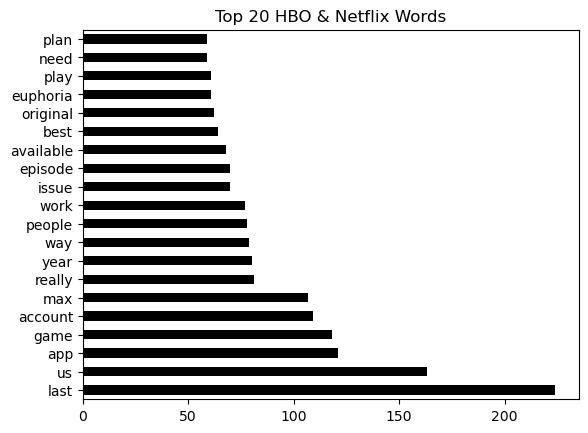

In [303]:
cvec2.sum().sort_values(ascending=False).head(20).plot(kind='barh', color = 'black',title='Top 20 HBO & Netflix Words');

In [304]:
cvec2.to_csv('../data/cvec2.csv')

#### Count Vectorizer with n-grams

In [305]:
cvec_bigrams = CountVectorizer(ngram_range= (2,2), stop_words=stopwords)
cvec_bigrams.fit(hbo_netflix['tokens_lem'])
cvec_bigrams2 = pd.DataFrame(cvec_bigrams.transform(hbo_netflix['tokens_lem']).toarray(), columns=cvec_bigrams.get_feature_names_out())

/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mustn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


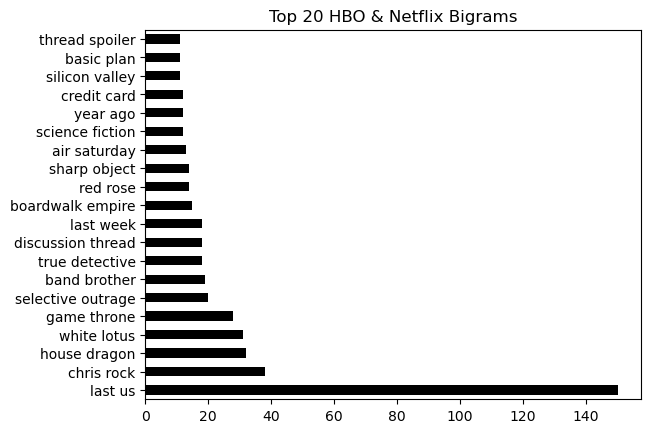

In [306]:
cvec_bigrams2.sum().sort_values(ascending=False).head(20).plot(kind='barh', color = 'black', title='Top 20 HBO & Netflix Bigrams');

/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mustn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


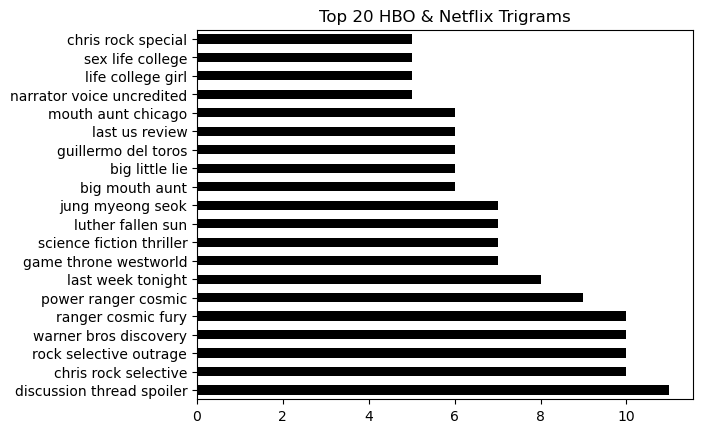

In [307]:
cvec_trigrams = CountVectorizer(ngram_range= (3,3), stop_words=stopwords)
cvec_trigrams.fit(hbo_netflix['tokens_lem'])
cvec_trigrams2 = pd.DataFrame(cvec_trigrams.transform(hbo_netflix['tokens_lem']).toarray(), columns=cvec_trigrams.get_feature_names_out())
cvec_trigrams2.sum().sort_values(ascending=False).head(20).plot(kind='barh', color='black',title='Top 20 HBO & Netflix Trigrams');

/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mustn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


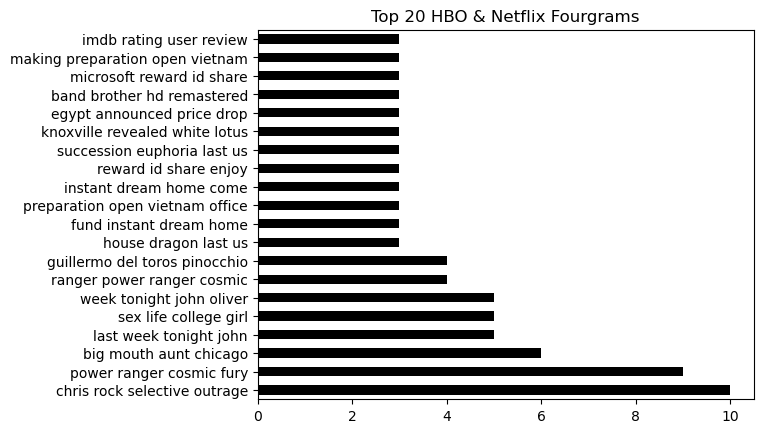

In [308]:
cvec_fourgrams = CountVectorizer(ngram_range= (4,4), stop_words=stopwords)
cvec_fourgrams.fit(hbo_netflix['tokens_lem'])
cvec_fourgrams2 = pd.DataFrame(cvec_fourgrams.transform(hbo_netflix['tokens_lem']).toarray(), columns=cvec_fourgrams.get_feature_names_out())
cvec_fourgrams2.sum().sort_values(ascending=False).head(20).plot(kind='barh', color= 'black', title='Top 20 HBO & Netflix Fourgrams');  

I will use bigrams as it contains the highest occurrences of relevant keywords compared to trigrams and four-grams.

In [309]:
cvec_bigrams2.to_csv('../data/cvec_bigrams2.csv')

#### TF-IDF Vectorizer

In [310]:
cvec_tfidf = TfidfVectorizer()
cvec_tfidf.fit(hbo_netflix['tokens_lem'])
cvec_tfidf2 = pd.DataFrame(cvec_tfidf.transform(hbo_netflix['tokens_lem']).toarray(), columns=cvec_tfidf.get_feature_names_out())

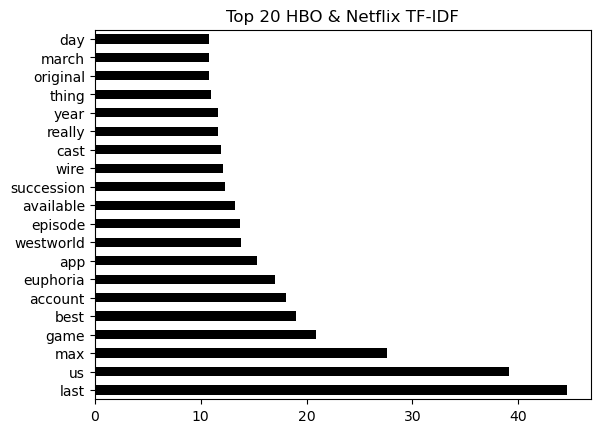

In [311]:
cvec_tfidf2.sum().sort_values(ascending=False).head(20).plot(kind='barh', color='black', title='Top 20 HBO & Netflix TF-IDF');

In [312]:
cvec_tfidf2.to_csv('../data/cvec_tfidf2.csv')